# Import packages and utils

In [1]:
import logging
import time
from contextlib import contextmanager
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
import multiprocessing_logging
from src.utils._get_data import DataHandler
import matplotlib.pyplot as plt
import seaborn as sns
# after setting up your logger
logging.basicConfig(level=logging.INFO)
multiprocessing_logging.install_mp_handler()


In [2]:
# Create a context manager for timing sections of code
@contextmanager
def log_time(section_name: str):
    """
    Context manager for timing sections of your code. 
    It logs completion time on successful completion of the with block.
    """
    start_time = time.time()
    yield
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info(f"{section_name} completed in {elapsed_time} seconds")


# Dataset

## 1. Load Datasets

Please see the DataHandler class from the following path for detailed implementation
* `src.utils._get_data.py -> DataHandler()`

In [154]:
# Describe the data you want to get
data_names = [
    'load_data',
    'load_forecast',
    'generation_data',
    'generation_forecast',
    'wind_and_solar_forecast',
    'day_ahead_prices',
    'weather_data'
]

# Describe the country code, start and end dates
country_code = 'DE_LU'
start = pd.Timestamp('2023-01-01', tz='Europe/Berlin')
end = pd.Timestamp('2023-06-01', tz='Europe/Berlin')


#### Add multiprocessing to speed up data loading process

In [155]:
# function to load a single dataset
def load_single_dataset(args):
    dataset_name, data_handler = args
    try:
        with log_time(dataset_name):
            df = data_handler._get_data(dataset_name)
            logging.info(f"{dataset_name} data retrieved successfully")
            return dataset_name, df
    except Exception as e:
        logging.error(f"Error while loading {dataset_name}: {e}")
        raise e

def load_dataset():
    df_dict = {} # Dictionary to store the dataframes
    try:
        with log_time("DataHandler"):
            data_handler = DataHandler()
            logging.info("DataHandler object created successfully")
            data_handler._set_data_settings(country_code, start, end)
            logging.info("DataHandler settings set successfully")
            with Pool(cpu_count()) as pool:
                results = pool.map(load_single_dataset, [(name, data_handler) for name in data_names])
            for dataset_name, df in results:
                df_dict[dataset_name] = df
    except Exception as e:
        logging.error(f"Error while creating DataHandler: {e}")
        raise e

    return df_dict

In [156]:
df_dict = load_dataset()

INFO:root:DataHandler object created successfully
INFO:root:DataHandler settings set successfully
/home/mamur/EON/forecast-electricity-prices/src/utils/_get_data.py:80: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(self.weather_data_path, index_col=0, parse_dates=True)
INFO:root:weather_data data retrieved successfully
INFO:root:weather_data completed in 0.0663142204284668 seconds
INFO:root:generation_forecast data retrieved successfully
INFO:root:generation_forecast completed in 2.626438617706299 seconds
INFO:root:load_data data retrieved successfully
INFO:root:load_data completed in 3.54872727394104 seconds
INFO:root:load_forecast data retrieved successfully
INFO:root:load_forecast completed in 4.007753133773804 seconds
INFO:root:day_ahead_prices data retrieved successfully
INFO:root:day_ahead_prices completed in 7.38875389099121

## 2. Exploration and Analysis of Dataset

In [157]:
# Prin the type of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {type(df)}")
    

load_data: <class 'pandas.core.frame.DataFrame'>
load_forecast: <class 'pandas.core.frame.DataFrame'>
generation_data: <class 'pandas.core.frame.DataFrame'>
generation_forecast: <class 'pandas.core.frame.DataFrame'>
wind_and_solar_forecast: <class 'pandas.core.frame.DataFrame'>
day_ahead_prices: <class 'pandas.core.frame.DataFrame'>
weather_data: <class 'pandas.core.frame.DataFrame'>


In [158]:
# print the columns of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.columns}")
    

load_data: Index(['Actual Load'], dtype='object')
load_forecast: Index(['Forecasted Load'], dtype='object')
generation_data: MultiIndex([(                        'Biomass',  'Actual Aggregated'),
            (      'Fossil Brown coal/Lignite',  'Actual Aggregated'),
            (                     'Fossil Gas',  'Actual Aggregated'),
            (               'Fossil Hard coal',  'Actual Aggregated'),
            (                     'Fossil Oil',  'Actual Aggregated'),
            (                     'Geothermal',  'Actual Aggregated'),
            (           'Hydro Pumped Storage',  'Actual Aggregated'),
            (           'Hydro Pumped Storage', 'Actual Consumption'),
            ('Hydro Run-of-river and poundage',  'Actual Aggregated'),
            (          'Hydro Water Reservoir',  'Actual Aggregated'),
            (                        'Nuclear',  'Actual Aggregated'),
            (                          'Other',  'Actual Aggregated'),
            (          

In [159]:
# print the frequency and length of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.index.freq} {len(df)}")
    

load_data: <15 * Minutes> 14492
load_forecast: <15 * Minutes> 14492
generation_data: <15 * Minutes> 14492
generation_forecast: <60 * Minutes> 3623
wind_and_solar_forecast: <15 * Minutes> 14492
day_ahead_prices: <60 * Minutes> 3624
weather_data: None 3625


In [160]:
df_dict['load_data'].index

DatetimeIndex(['2023-01-01 00:00:00+01:00', '2023-01-01 00:15:00+01:00',
               '2023-01-01 00:30:00+01:00', '2023-01-01 00:45:00+01:00',
               '2023-01-01 01:00:00+01:00', '2023-01-01 01:15:00+01:00',
               '2023-01-01 01:30:00+01:00', '2023-01-01 01:45:00+01:00',
               '2023-01-01 02:00:00+01:00', '2023-01-01 02:15:00+01:00',
               ...
               '2023-05-31 21:30:00+02:00', '2023-05-31 21:45:00+02:00',
               '2023-05-31 22:00:00+02:00', '2023-05-31 22:15:00+02:00',
               '2023-05-31 22:30:00+02:00', '2023-05-31 22:45:00+02:00',
               '2023-05-31 23:00:00+02:00', '2023-05-31 23:15:00+02:00',
               '2023-05-31 23:30:00+02:00', '2023-05-31 23:45:00+02:00'],
              dtype='datetime64[ns, Europe/Berlin]', length=14492, freq='15T')

In [161]:
# print the data types of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.dtypes}")

load_data: Actual Load    float64
dtype: object
load_forecast: Forecasted Load    float64
dtype: object
generation_data: Biomass                          Actual Aggregated     float64
Fossil Brown coal/Lignite        Actual Aggregated     float64
Fossil Gas                       Actual Aggregated     float64
Fossil Hard coal                 Actual Aggregated     float64
Fossil Oil                       Actual Aggregated     float64
Geothermal                       Actual Aggregated     float64
Hydro Pumped Storage             Actual Aggregated     float64
                                 Actual Consumption    float64
Hydro Run-of-river and poundage  Actual Aggregated     float64
Hydro Water Reservoir            Actual Aggregated     float64
Nuclear                          Actual Aggregated     float64
Other                            Actual Aggregated     float64
Other renewable                  Actual Aggregated     float64
Solar                            Actual Aggregated     float

In [162]:
# describe load_Data
df_dict['load_data'].describe()

Actual Load
count  14492.000000
mean   55028.614408
std     8686.586100
min    35231.000000
25%    47802.000000
50%    54818.500000
75%    62692.500000
max    72402.000000

In [163]:
# describe load_forecast
df_dict['load_forecast'].describe()

Forecasted Load
count     14492.000000
mean      55790.010489
std        9168.626435
min       32959.000000
25%       48420.750000
50%       55892.000000
75%       63600.250000
max       74287.000000

In [164]:
df_dict['generation_data'].describe(include='all')

Biomass Fossil Brown coal/Lignite        Fossil Gas  \
      Actual Aggregated         Actual Aggregated Actual Aggregated   
count      13336.000000              14492.000000      14488.000000   
mean        4679.318611               9731.934930       6135.536099   
std          200.653334               3599.767492       2903.868412   
min         4216.000000               3140.000000       1920.000000   
25%         4527.000000               6718.250000       3980.500000   
50%         4659.500000               9565.500000       5398.000000   
75%         4812.000000              12877.000000       7611.000000   
max         5196.000000              16487.000000      16142.000000   

       Fossil Hard coal        Fossil Oil        Geothermal  \
      Actual Aggregated Actual Aggregated Actual Aggregated   
count      14492.000000      14492.000000      14492.000000   
mean        5684.596329         68.020011         24.711220   
std         3848.377807        115.429494          3.636002   
min          987.000000          8.000000         15.000000   
25%         2352.750000          8.000000         22.000000   
50%         4692.500000          8.000000         23.000000   
75%         7963.000000         27.000000         28.000000   
max        15256.000000        591.000000         32.000000   

      Hydro Pumped Storage                    Hydro Run-of-river and poundage  \
         Actual Aggregated Actual Consumption               Actual Aggregated   
count         14492.000000       14492.000000                    14488.000000   
mean           1381.946660        1751.920232                     1387.953548   
std            1879.309556        2116.938270                      297.230923   
min               0.000000           0.000000                      968.000000   
25%             170.000000         170.000000                     1167.000000   
50%             447.000000         700.000000                     1283.000000   
75%            1832.000000        2808.250000                     1493.000000   
max            9596.000000        8713.000000                     2084.000000   

      Hydro Water Reservoir           Nuclear             Other  \
          Actual Aggregated Actual Aggregated Actual Aggregated   
count          14488.000000      11962.000000      14492.000000   
mean              92.549696       2254.050911        231.182445   
std               71.839562       1018.028673         52.508937   
min                2.000000          0.000000        125.000000   
25%               36.000000       2134.000000        191.000000   
50%               72.000000       2700.000000        231.000000   
75%              128.000000       2914.000000        268.000000   
max              432.000000       3084.000000        349.000000   

        Other renewable             Solar                     \
      Actual Aggregated Actual Aggregated Actual Consumption   
count      14492.000000      14488.000000            14488.0   
mean         127.096260       5607.255315                0.0   
std           23.443318       8937.645942                0.0   
min           85.000000          0.000000                0.0   
25%          107.000000          0.000000                0.0   
50%          127.000000         36.500000                0.0   
75%          144.000000       8559.250000                0.0   
max          175.000000      40996.000000                0.0   

                  Waste     Wind Offshore      Wind Onshore                     
      Actual Aggregated Actual Aggregated Actual Aggregated Actual Consumption  
count      14488.000000      14492.000000      14488.000000            14488.0  
mean         762.287686       2791.879727      14411.691814                0.0  
std           96.094520       1798.363288      10458.960897                0.0  
min          318.000000          0.000000        223.000000                0.0  
25%          707.000000       1152.000000       6181.750000      

In [165]:
# describe generation_forecast
df_dict['generation_forecast'].describe()

forecasted_generation
count            3623.000000
mean            54298.918852
std             11592.248919
min             23520.000000
25%             45997.000000
50%             54679.000000
75%             62616.500000
max             87192.000000

In [166]:
# describe wind_and_solar_forecast
df_dict['wind_and_solar_forecast'].describe()

Solar  Wind Offshore  Wind Onshore
count  14492.000000   14492.000000  14492.000000
mean    5574.167196    2858.622619  14451.015319
std     8876.304255    1697.801492  10402.914078
min        0.000000      33.000000    242.000000
25%        0.000000    1303.000000   6207.250000
50%       76.000000    2935.500000  12074.500000
75%     8454.000000    4362.000000  20037.500000
max    41763.000000    6382.000000  43242.000000

In [167]:
# describe day_ahead_prices
df_dict['day_ahead_prices'].describe()

day_ahead_price
count      3624.000000
mean        105.816802
std          46.371598
min        -129.960000
25%          84.025000
50%         106.835000
75%         133.975000
max         270.220000

In [168]:
# find the number of NaNs in each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.isna().sum()}")
    

load_data: Actual Load    0
dtype: int64
load_forecast: Forecasted Load    0
dtype: int64
generation_data: Biomass                          Actual Aggregated     1156
Fossil Brown coal/Lignite        Actual Aggregated        0
Fossil Gas                       Actual Aggregated        4
Fossil Hard coal                 Actual Aggregated        0
Fossil Oil                       Actual Aggregated        0
Geothermal                       Actual Aggregated        0
Hydro Pumped Storage             Actual Aggregated        0
                                 Actual Consumption       0
Hydro Run-of-river and poundage  Actual Aggregated        4
Hydro Water Reservoir            Actual Aggregated        4
Nuclear                          Actual Aggregated     2530
Other                            Actual Aggregated        0
Other renewable                  Actual Aggregated        0
Solar                            Actual Aggregated        4
                                 Actual Consumption  

Most of the nuclear columns are missing in generation data. Let's visualize each dataset individually and see what we can do for those missing values before the feature engineering. Also the good news that there are no NaN in price dataset which we want to predict it. So only generation dataset is problematic 

## 3. Visualize the Datasets

### 1. Visualizing Individual Datasets

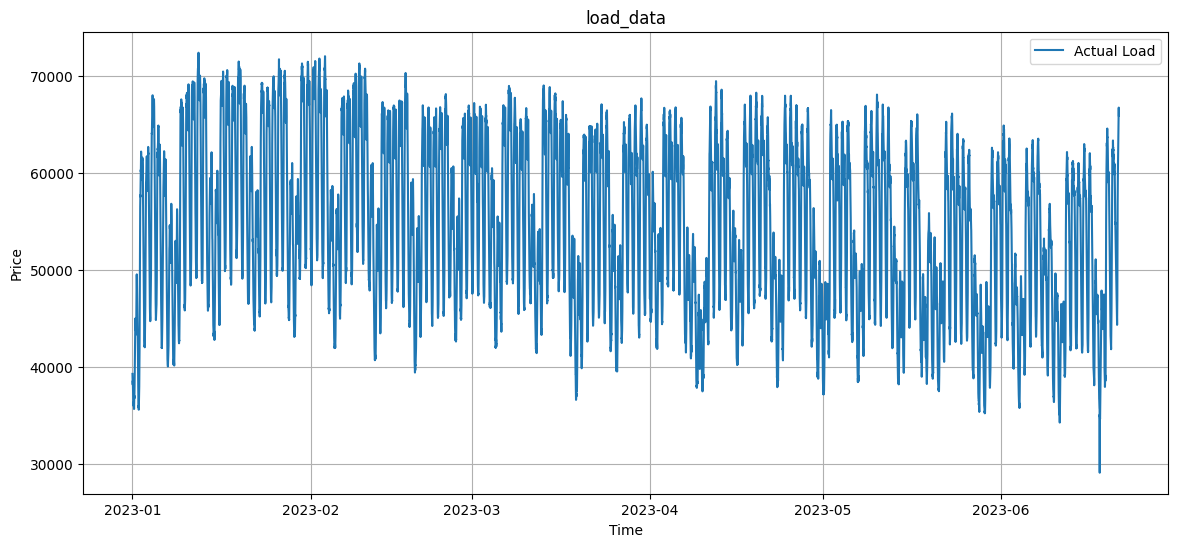

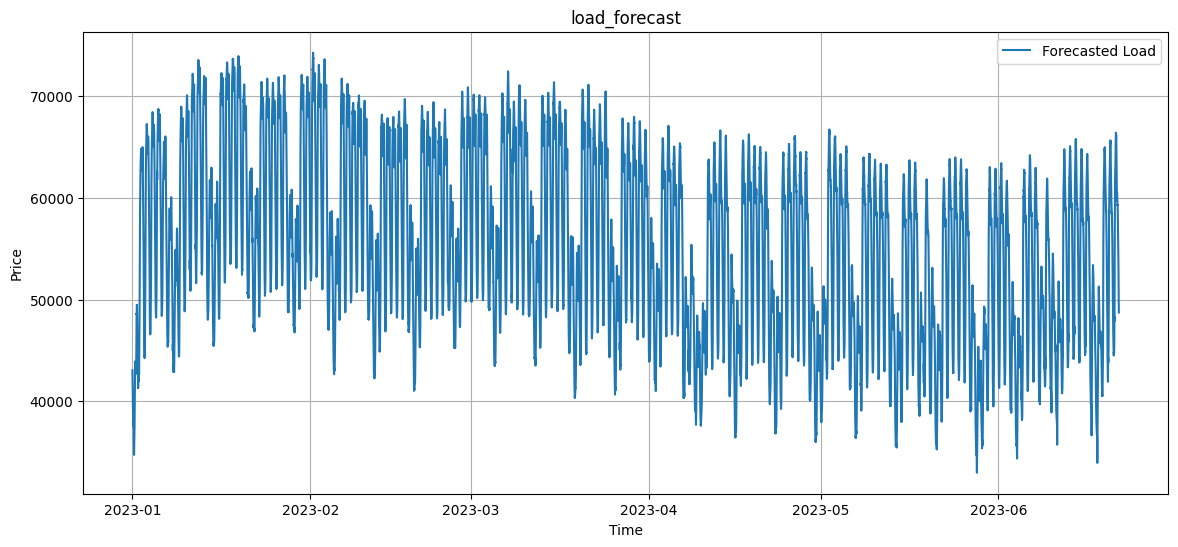

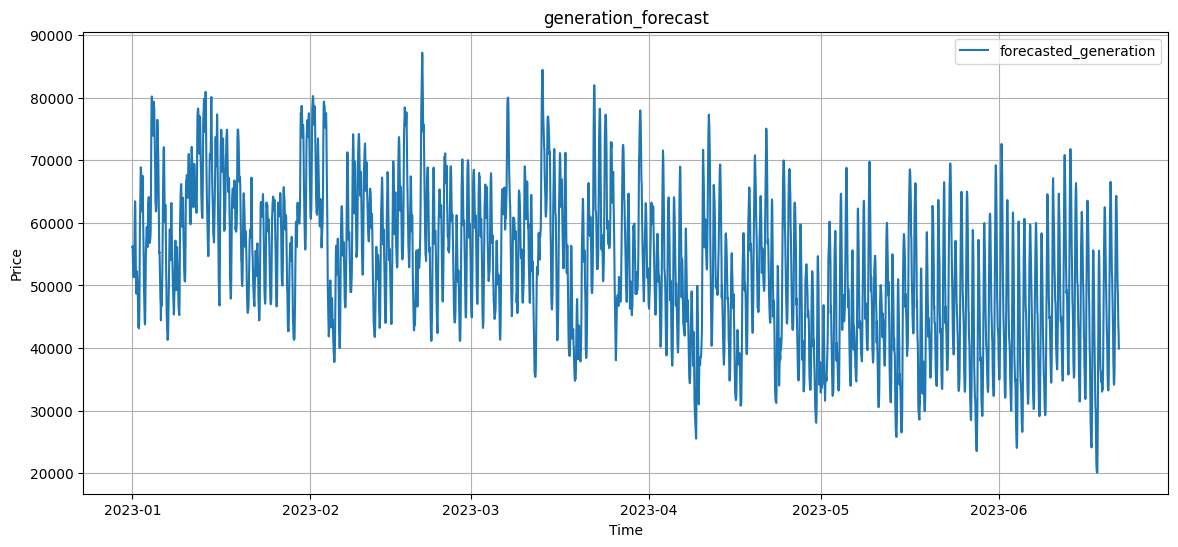

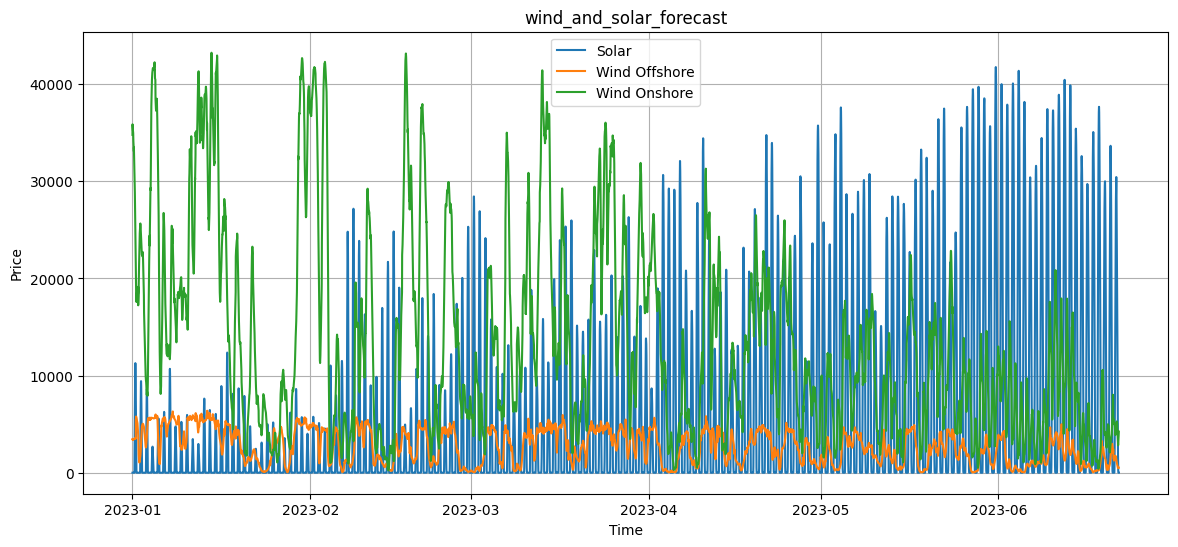

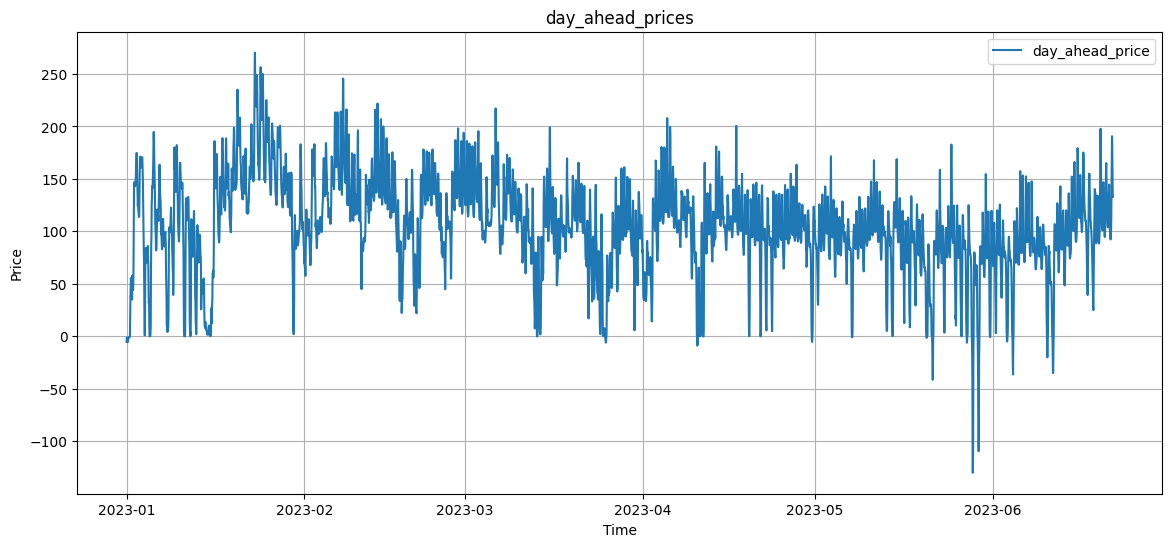

In [18]:
# plot each dataset in the dictionary except generation_data because it is multi-dimensional(indexed)
for dataset_name, df in df_dict.items():
    if dataset_name not in ['generation_data', 'weather_data']:
        plt.figure(figsize=(14,6))
        plt.plot(df)
        plt.title(dataset_name)
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.grid(True)
        # add legend
        plt.legend(df.columns)
        plt.show()

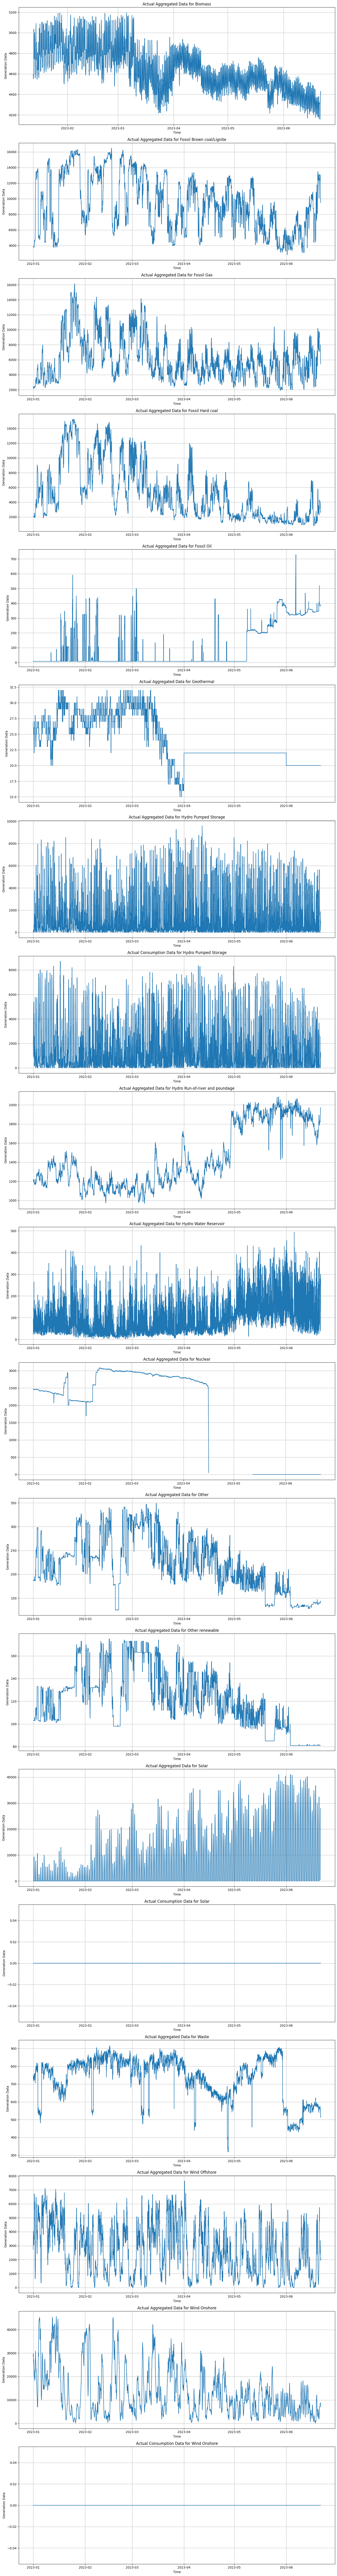

In [19]:
# Plot generation_data
fig, ax = plt.subplots(len(df_dict['generation_data'].columns), 1, figsize=(15, 6*len(df_dict['generation_data'].columns)))

for i, col in enumerate(df_dict['generation_data'].columns):
    ax[i].plot(df_dict['generation_data'][col])
    ax[i].set_title(f'{col[1]} Data for {col[0]}')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Generation Data')
    ax[i].grid(True)

plt.tight_layout()
plt.show()


As you can see that we have nested columns for same cases (e.g. Actual Aggregated, Actual Consumption)
* "Actual Aggregated" typically refers to the total generated power from a particular source
* "Actual Consumption" denotes the amount of that power which is consumed.

some cases, the consumption is zero or near zero. This could happen when the power generated from a source like solar is stored instead of being consumed immediately. For example, during periods of low demand but high solar output (such as midday), the generated solar power could be stored for later use.

air_temperature_berlin
visibility_berlin
wind_speed_berlin
wind_direction_berlin
air_temperature_frankfurt
visibility_frankfurt
wind_speed_frankfurt
wind_direction_frankfurt
air_temperature_munich
visibility_munich
wind_speed_munich
wind_direction_munich


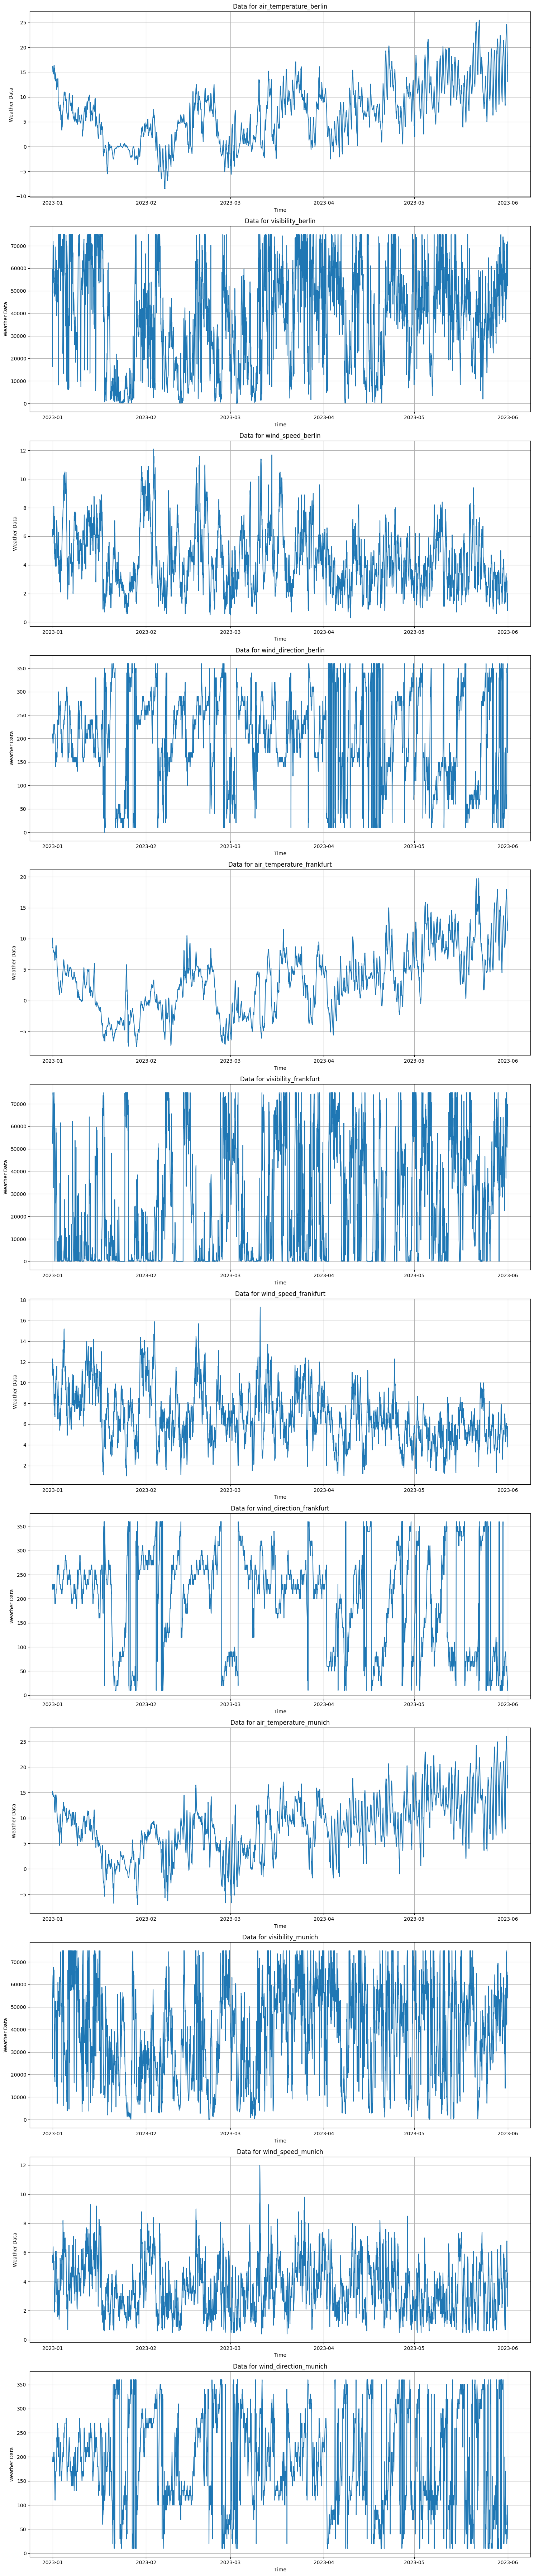

In [20]:
# Plot generation_data
fig, ax = plt.subplots(len(df_dict['weather_data'].columns), 1, figsize=(15, 6*len(df_dict['weather_data'].columns)))

for i, col in enumerate(df_dict['weather_data'].columns):
    print(col)
    ax[i].plot(df_dict['weather_data'][col])
    ax[i].set_title(f'Data for {col}')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Weather Data')
    ax[i].grid(True)

plt.tight_layout()
plt.show()

### 2. Visualizing Relationships

#### 2.1 Acutal Load vs Forecasted Load
 how accurate the load forecasts are when compared to actual load.

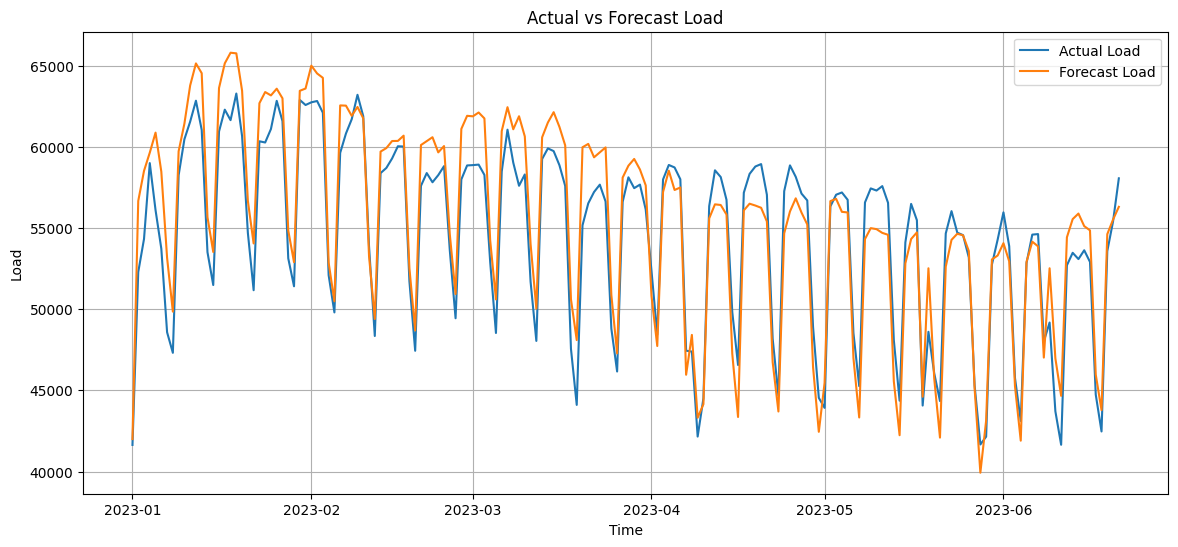

In [21]:
# Let's create a combined DataFrame
combined_df = pd.concat([df_dict['load_data'].resample('D').mean(), 
                         df_dict['load_forecast'].resample('D').mean()], axis=1)
combined_df.columns = ['Actual Load', 'Forecast Load']


plt.figure(figsize=(14,6))
plt.plot(combined_df)
plt.title('Actual vs Forecast Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.grid(True)
# add legend
plt.legend(combined_df.columns)
plt.show()


#### 2.2 Actual Load and Actual Total Generation
how well supply (generation) is meeting demand (load). If generation is consistently below load, it may indicate capacity issues.

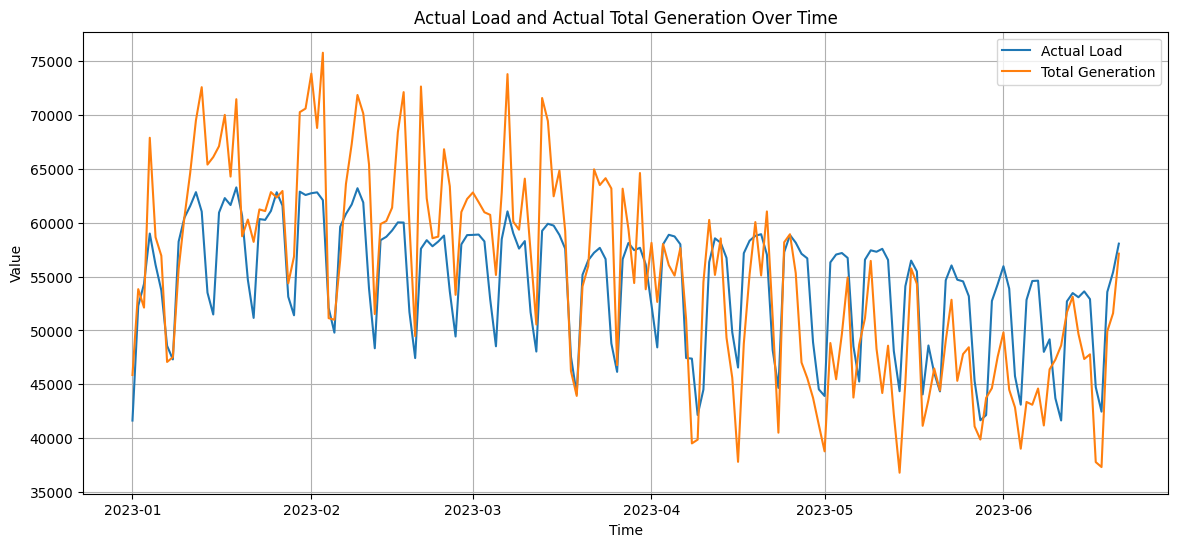

In [22]:
# Let's create a combined DataFrame
combined_df = pd.concat([df_dict['load_data'].resample('D').mean(), 
                         df_dict['generation_data'].resample('D').mean().sum(axis=1)], axis=1)
combined_df.columns = ['Actual Load', 'Total Generation']


plt.figure(figsize=(14,6))

plt.plot(combined_df['Actual Load'], label='Actual Load')
plt.plot(combined_df['Total Generation'], label='Total Generation')

plt.title('Actual Load and Actual Total Generation Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### 2.3 Generation Breakdown
 bar chart that shows the proportion of total generation from each source (solar, wind, fossil fuels, etc.). This will give you an idea of the energy mix.

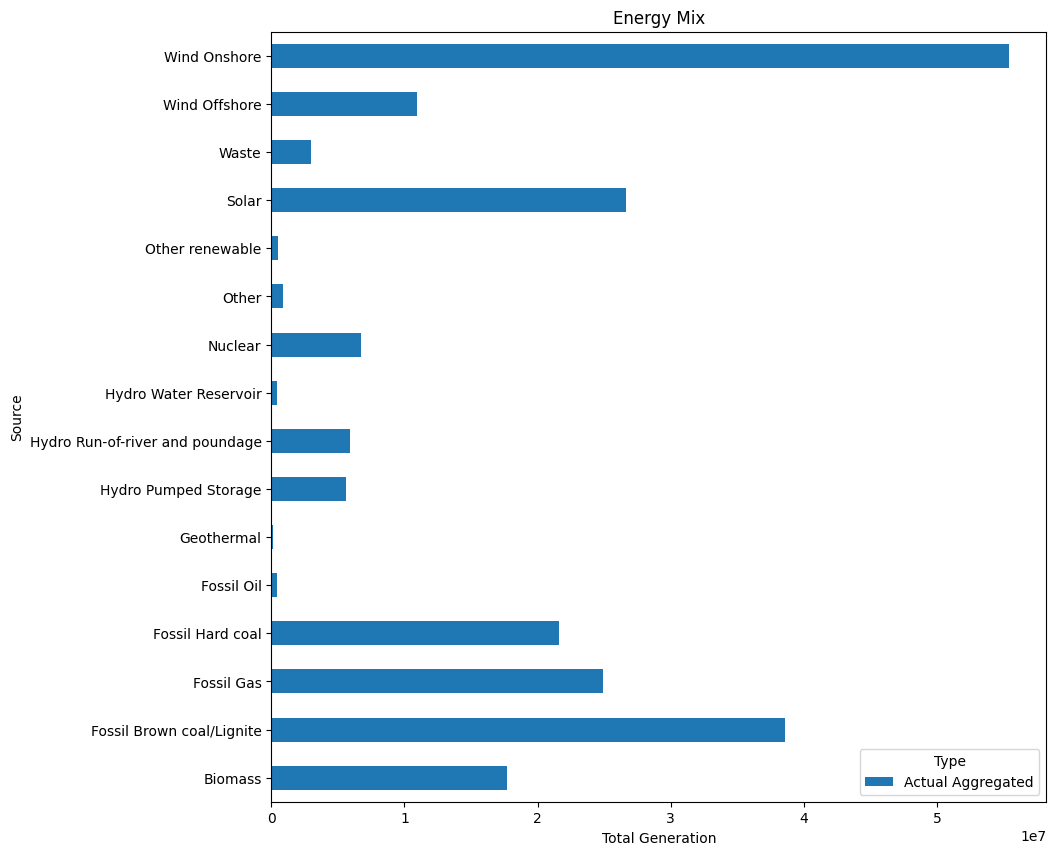

In [23]:
# Sum the generation data across the entire timespan for each source
gen_totals = df_dict['generation_data'].resample('1H').mean().sum()

# Remove actual consumption columns
gen_totals = gen_totals.loc[gen_totals.index.get_level_values(1) == 'Actual Aggregated']

# Convert to DataFrame and transpose for plotting
gen_totals_df = gen_totals.reset_index()
gen_totals_df.columns = ['Source', 'Type', 'Total Generation']
gen_totals_df = gen_totals_df.pivot(index='Type', columns='Source', values='Total Generation').T

# Create the stacked bar chart
gen_totals_df.plot(kind='barh', stacked=True, figsize=(10, 10))
plt.title('Energy Mix')
plt.xlabel('Total Generation')
plt.ylabel('Source')
plt.show()


As you can see most of the energy generation comes from wind onshore. BINGO ! weather information should overlap with this 

#### 2.4 Forecasted Generation and Actual Total Generation

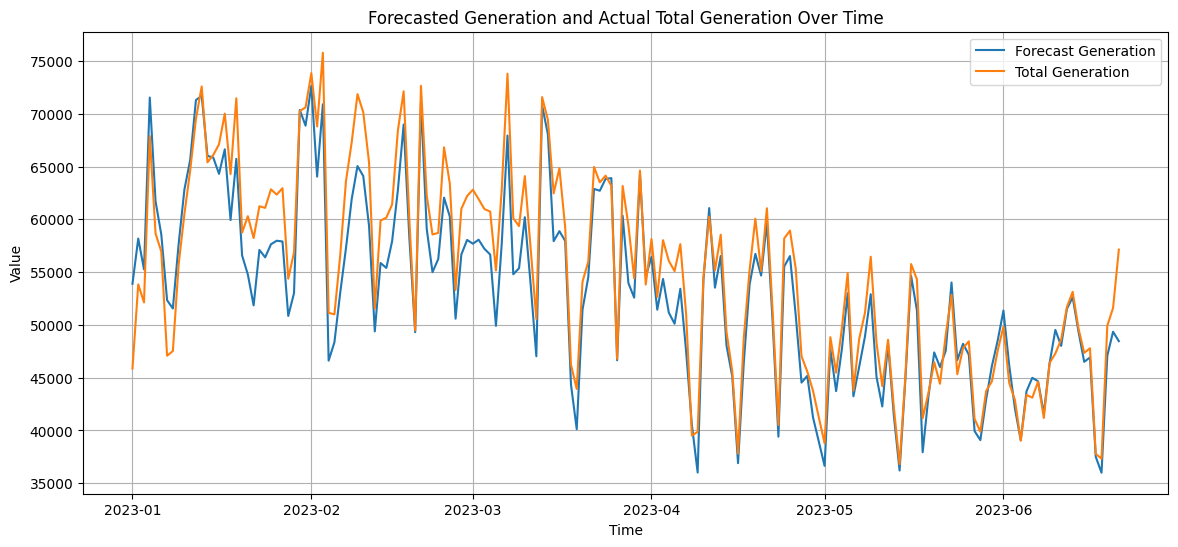

In [24]:
# Let's create a combined DataFrame
combined_df = pd.concat([df_dict['generation_forecast'].resample('D').mean(), 
                         df_dict['generation_data'].resample('D').mean().sum(axis=1)], axis=1)
combined_df.columns = ['Forecast Generation', 'Total Generation']


plt.figure(figsize=(14,6))

plt.plot(combined_df['Forecast Generation'], label='Forecast Generation')
plt.plot(combined_df['Total Generation'], label='Total Generation')

plt.title('Forecasted Generation and Actual Total Generation Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()




### 3. Inspecting Distributions

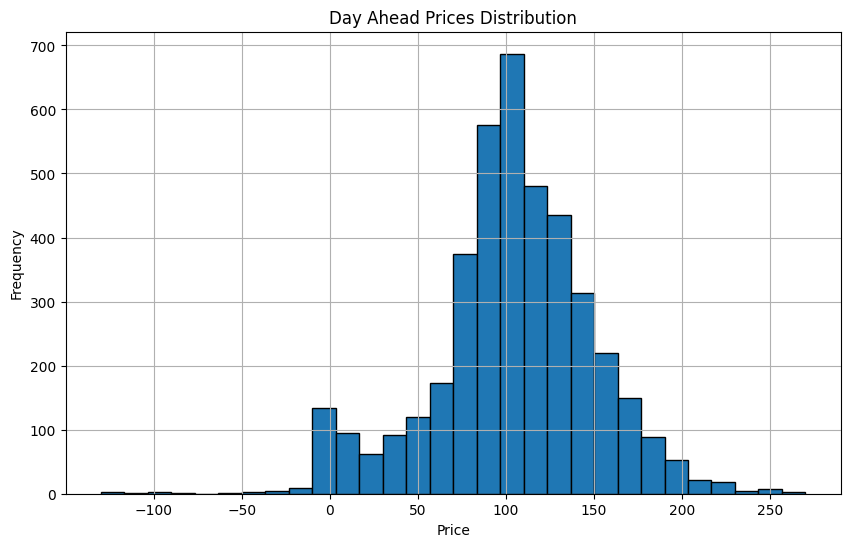

In [25]:
plt.figure(figsize=(10,6))
plt.hist(df_dict['day_ahead_prices'].values, bins=30, edgecolor='black')
plt.title('Day Ahead Prices Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### 4. Heatmap for Correlation

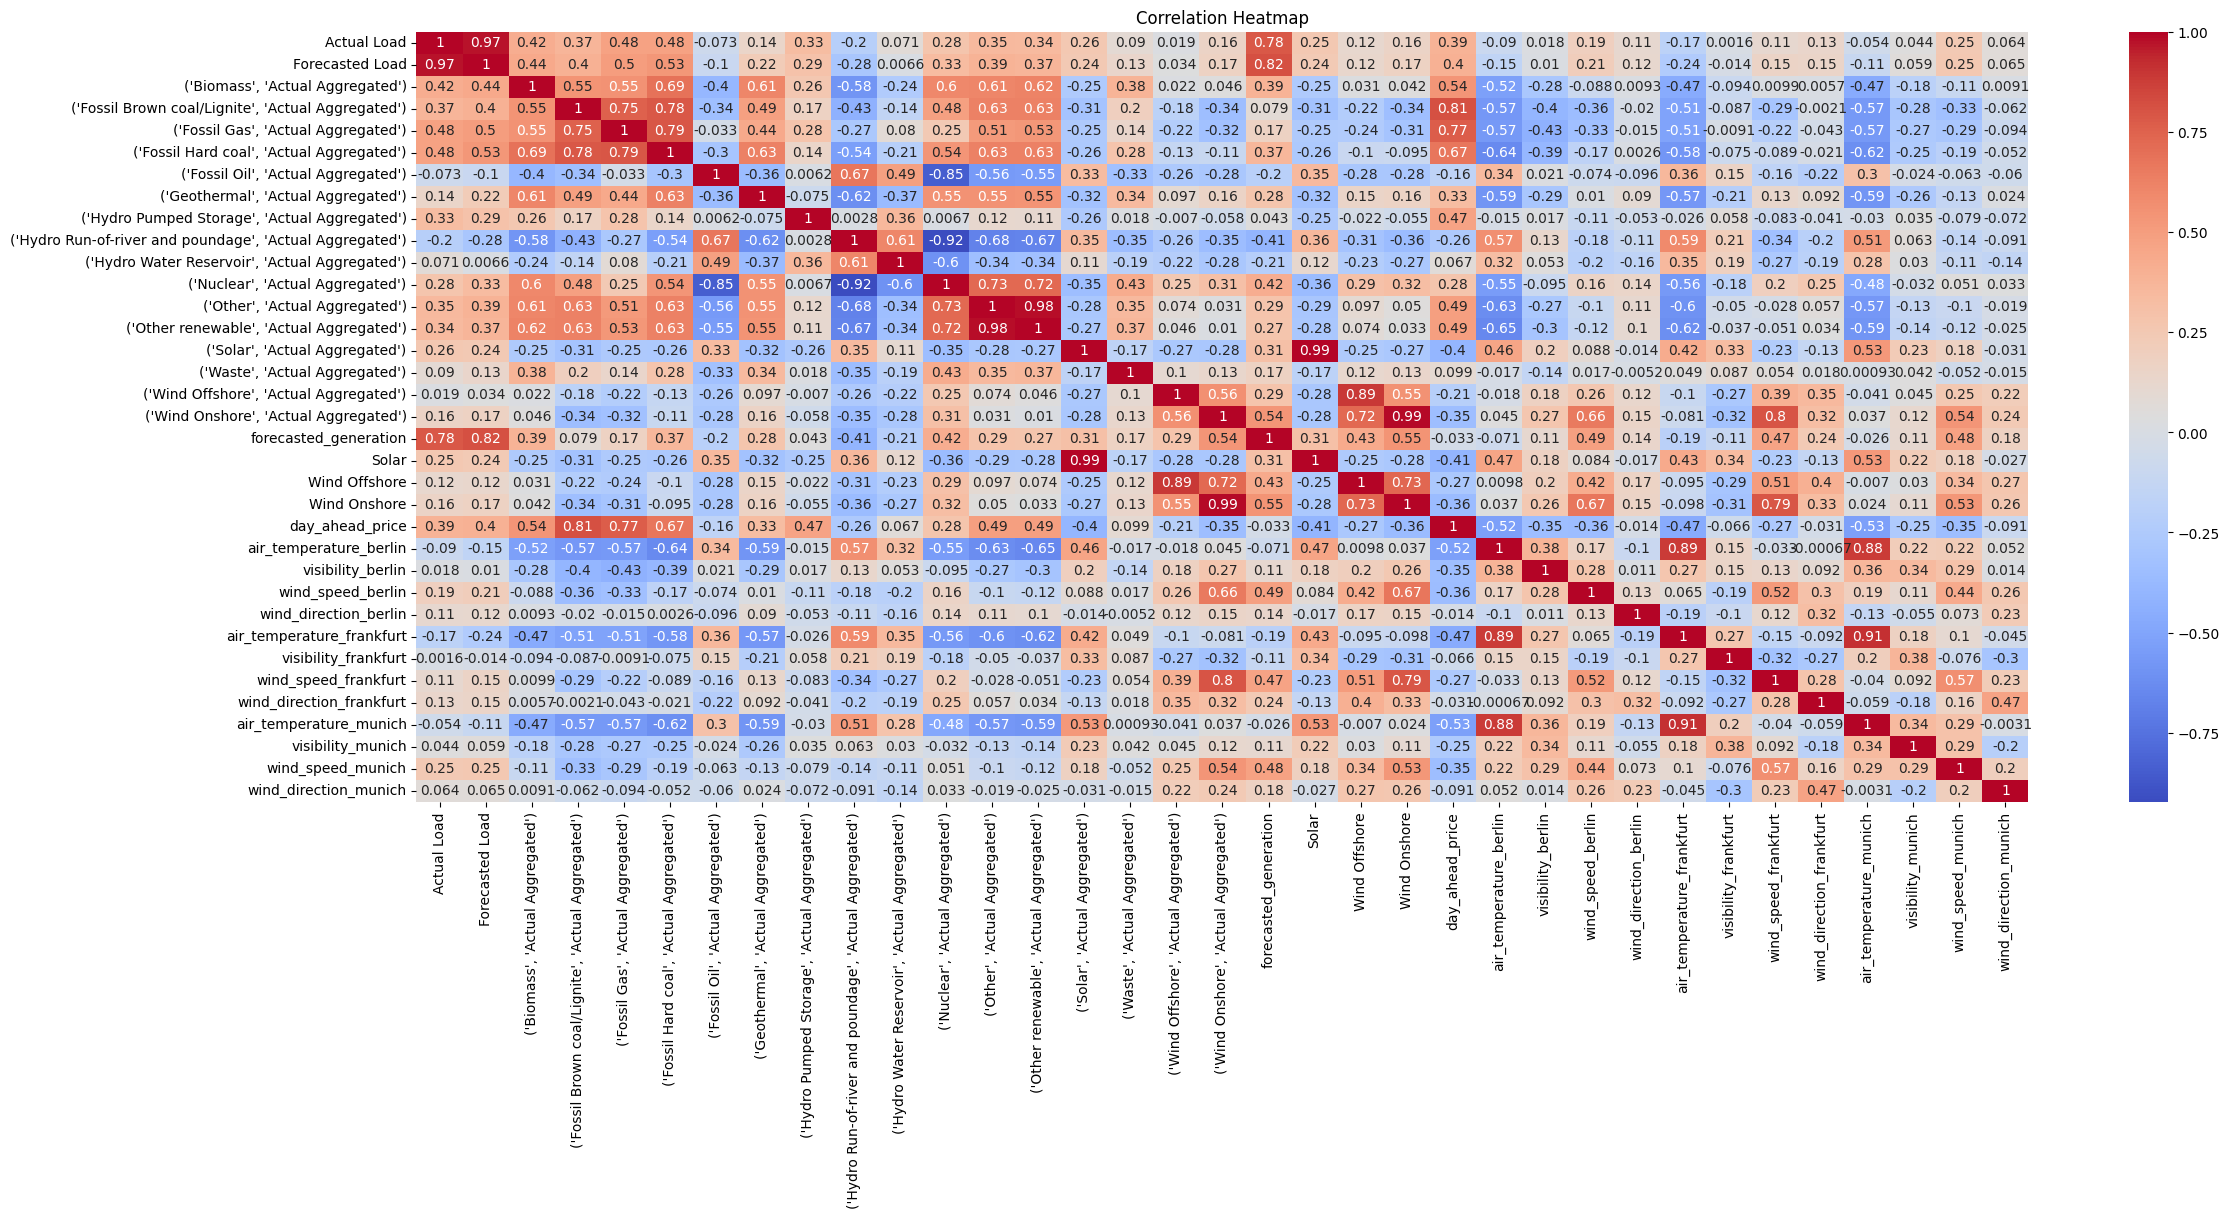

In [27]:
# Resample all dataframes to have the same hourly frequency and drop 'Actual Consumption' columns
resampled_dfs = []
for df in df_dict.values():
    # Drop 'Actual Consumption' columns if present
    df = df[df.columns.drop(list(df.filter(regex='Actual Consumption')))]
    resampled_dfs.append(df.resample('1H').mean())

# Combine into a single DataFrame
combined_df = pd.concat(resampled_dfs, axis=1)

# Calculate correlation
correlation = combined_df.corr()

# Use seaborn to create a heatmap
plt.figure(figsize=(26, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()




In [30]:
correlation

Actual Load  \
Actual Load                                            1.000000   
Forecasted Load                                        0.970795   
(Biomass, Actual Aggregated)                           0.418345   
(Fossil Brown coal/Lignite, Actual Aggregated)         0.370583   
(Fossil Gas, Actual Aggregated)                        0.479376   
(Fossil Hard coal, Actual Aggregated)                  0.479807   
(Fossil Oil, Actual Aggregated)                       -0.072712   
(Geothermal, Actual Aggregated)                        0.141766   
(Hydro Pumped Storage, Actual Aggregated)              0.325877   
(Hydro Run-of-river and poundage, Actual Aggreg...    -0.202560   
(Hydro Water Reservoir, Actual Aggregated)             0.070803   
(Nuclear, Actual Aggregated)                           0.275237   
(Other, Actual Aggregated)                             0.347367   
(Other renewable, Actual Aggregated)                   0.344729   
(Solar, Actual Aggregated)                             0.255512   
(Waste, Actual Aggregated)                             0.090488   
(Wind Offshore, Actual Aggregated)                     0.019281   
(Wind Onshore, Actual Aggregated)                      0.155795   
forecasted_generation                                  0.783155   
Solar                                                  0.250261   
Wind Offshore                                          0.116723   
Wind Onshore                                           0.157752   
day_ahead_price                                        0.391225   
air_temperature_berlin                                -0.089829   
visibility_berlin                                      0.017958   
wind_speed_berlin                                      0.191347   
wind_direction_berlin                                  0.107203   
air_temperature_frankfurt                             -0.173652   
visibility_frankfurt                                   0.001604   
wind_speed_frankfurt                                   0.113397   
wind_direction_frankfurt                               0.132864   
air_temperature_munich                                -0.054484   
visibility_munich                                      0.043986   
wind_speed_munich                                      0.246109   
wind_direction_munich                                  0.063856   

                                                    Forecasted Load  \
Actual Load                                                0.970795   
Forecasted Load                                            1.000000   
(Biomass, Actual Aggregated)                               0.443409   
(Fossil Brown coal/Lignite, Actual Aggregated)             0.396685   
(Fossil Gas, Actual Aggregated)                            0.500760   
(Fossil Hard coal, Actual Aggregated)                      0.527327   
(Fossil Oil, Actual Aggregated)                           -0.100557   
(Geothermal, Actual Aggregated)                            0.222082   
(Hydro Pumped Storage, Actual Aggregated)                  0.293548   
(Hydro Run-of-river and poundage, Actual Aggreg...        -0.283957   
(Hydro Water Reservoir, Actual Aggregated)                 0.006568   
(Nuclear, Actual Aggregated)                               0.332415   
(Other, Actual Aggregated)                                 0.385777   
(Other renewable, Actual Aggregated)                       0.373970   
(Solar, Actual Aggregated)                                 0.243586   
(Waste, Actual Aggregated)                                 0.130397   
(Wind Offshore, Actual Aggregated)                         0.033554   
(Wind Onshore, Actual Aggregated)                          0.171290   
forecasted_generation                                      0.816236   
Solar                                                      0.237771   
Wind Offshore                                              0.122127   
Wind Onshore                                               0.173980   
day_ah

Here we can see that electricity generation from fossil sources are the most correlated ones with the day_ahead_price data. So lets plot the relation between fossil source generation and day ahead prices

<Figure size 1000x600 with 0 Axes>

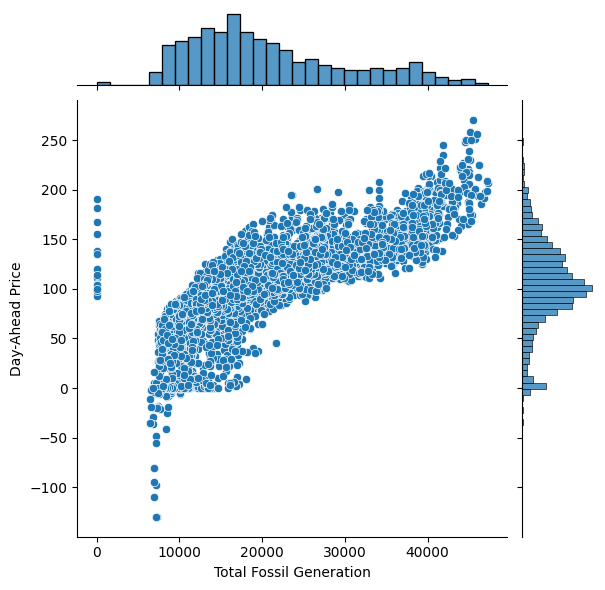

In [28]:
# First, let's create a total fossil generation feature by summing generation from fossil fuels
fossil_fuels = ['Fossil Brown coal/Lignite', 'Fossil Gas', 'Fossil Hard coal', 'Fossil Oil']
fossil_generation = df_dict['generation_data'][fossil_fuels].resample('1H').mean().sum(axis=1)

# Resample day_ahead_prices to the same hourly frequency
day_ahead_prices_resampled = df_dict['day_ahead_prices'].resample('1H').mean()

# Create a new DataFrame for fossil generation and day-ahead prices
df_fossil_price = pd.concat([fossil_generation, day_ahead_prices_resampled], axis=1)
df_fossil_price.columns = ['Total Fossil Generation', 'Day-Ahead Price']

# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.jointplot(x='Total Fossil Generation', y='Day-Ahead Price', data=df_fossil_price, kind='scatter')
plt.show()


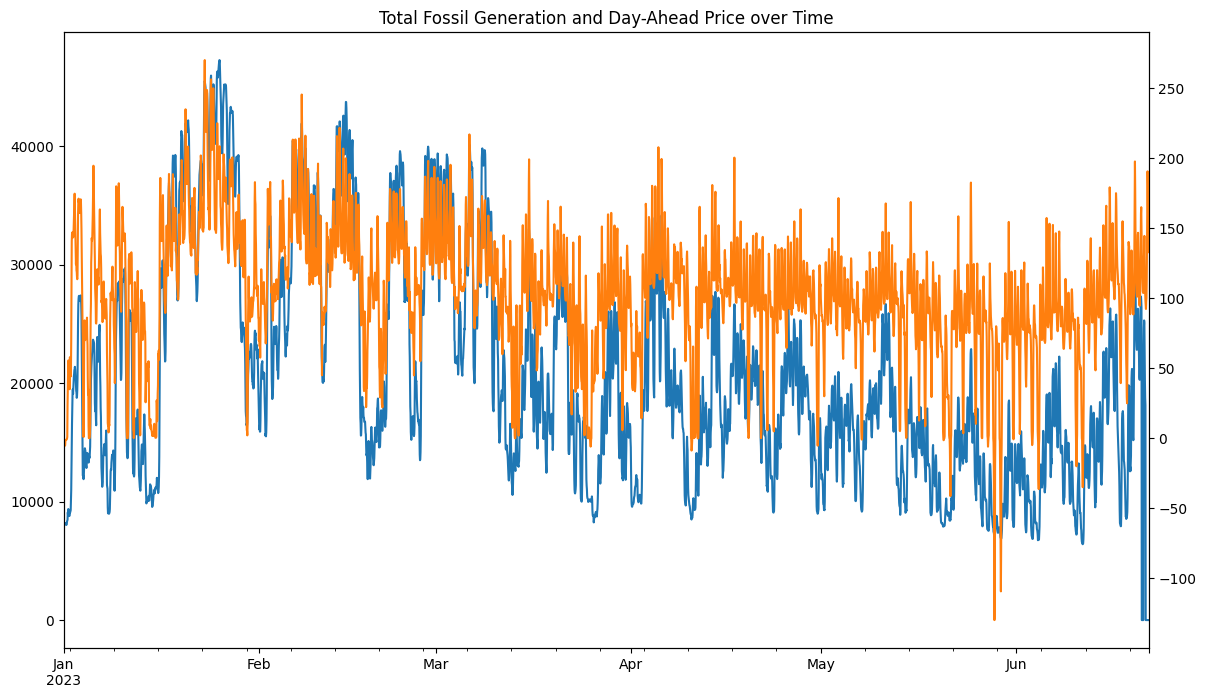

In [29]:
plt.figure(figsize=(14, 8))
df_fossil_price['Total Fossil Generation'].plot(label='Total Fossil Generation')
df_fossil_price['Day-Ahead Price'].plot(secondary_y=True, label='Day-Ahead Price')
plt.title('Total Fossil Generation and Day-Ahead Price over Time')
plt.show()


In [225]:
highly_correlated = abs(correlation[correlation > 0.60])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Actual Load                                           Forecasted Load                                         0.970795
                                                      forecasted_generation                                   0.783155
Forecasted Load                                       Actual Load                                             0.970795
                                                      forecasted_generation                                   0.816236
(Biomass, Actual Aggregated)                          (Fossil Hard coal, Actual Aggregated)                   0.689044
                                                      (Geothermal, Actual Aggregated)                         0.608961
                                                      (Other, Actual Aggregated)                              0.607078
                                                      (Other renewable, Actual Aggregated)                    0.617955
(Fossil Brown coal/Lignite, Actual Aggregated)  

### Findings of Data Visualization/Exploration
* Normal distribution of target variable

* Low percentage of nan values in columns without 100% nan.

* Some of columns with mostly 0 values for certain energy genreation types. ( Actual Consumption )

* Found very high correlation between some columns.
    * (Fossil Brown coal/Lignite, Actual Aggregated)          0.822241
    * (Fossil Gas, Actual Aggregated)                         0.772251
    * (Fossil Hard coal, Actual Aggregated)                   0.684282
    * (Biomass, Actual Aggregated)                            0.592185
    * Wind and Solar generation are highly correlated with the weather dataset
    
* All data seems to be numeric.


## 4. Data Preprocessing

1. Align Time Series: datasets have different frequencies. We need to align these to a common frequency, and then we can join these datasets. In our case, it seems reasonable to align to a 60-minute frequency (to match your target variable frequency). 

2. Lagging the data: Based on the constraint that we only have the actual load and generation data for day D-2 for predicting the prices for day D, so we need to create a lagged dataset. For instance, to predict the price for June 3, we would use the load and generation data from June 1.


3. Handling Missing Values: We need to decide how to handle these - common strategies are imputation (filling in with a statistic like mean or median), forward fill, backward fill, or simply dropping the rows with missing values. On the other hand we can use some external dataset to fill our missin nucler source (e.g. uranium prices). there should be high correlation between uranium prices and electricity generation from nuclear energy

    * Dealing with features with mostly zero values ("actual consumption" columns):

        * Only certain features have non-zero values so we can drop these columns.

    * Dealing with null values (specially with Nuclear and Biomass feature):

        * Of course we can consider to drop those feature but as we can see on the visualizations above nuclear energy generation has a valuable propotion in total electricity generation so this feature can be useful. And also biomass has a correlation with price so Instead of dropping we can consider to imputation it by using methods like mean,median, interpolation or even more complex methods like KNN or regression model etc.
    
4. Feature Selection: From the data visualization parts, it's clear that some features are highly correlated with the target variable. We might also find that some features are highly correlated with each other. We'll want to be cautious about including multiple features that are highly correlated with each other, as this can lead to multicollinearity, which can make the model's estimates unstable.


    * Dealing with features with high correlation:

        * The generation data features (specially fossil sources) highly correlated with price can be important features for modeling since they show a strong linear relationship with our target variable (price). Including these in our model may increase its performance.
        
        * The lower correlated features like 'Wind Onshore', 'Solar' are also important because they may provide some non-linear predictive power which is not captured by correlation.
        However, we have to be careful with highly correlated input features (multicollinearity), as they can destabilize the model. Depending on the model choice, we can drop or combine some of these features.


5. Creating the final dataset: After these steps, we can merge all datasets into a final single DataFrame.




### 4.1. Align Time Series

* Resample all data to target data frequency which is ('H')

In [194]:
# Call DataHandler Object
data_handler = DataHandler()

In [195]:
def resample_data(df_dict, freq='H'):
    """Resamples the dataframes in df_dict to the specified frequency"""
    resampled_dict = {}
    for dataset_name, df in df_dict.items():
        
        df_resampled = data_handler._resample_data(df, freq)
        resampled_dict[dataset_name] = df_resampled
    return resampled_dict

In [196]:
resampled_dict = resample_data(df_dict, freq='H')

### 4.2. Handling Missing Values

#### 4.2.1. Handle missing values in Nuclear Generation

* Since uranium is the essential for nuclear power plant maybe we can find some correlation between uranium prices and nuclear generation


In [178]:
resampled_dict_for_uranium = resample_data(df_dict, freq='D')

In [179]:
uranium_prices = pd.read_csv('/home/mamur/EON/forecast-electricity-prices/src/data/UEC.csv', index_col=0, parse_dates=True)

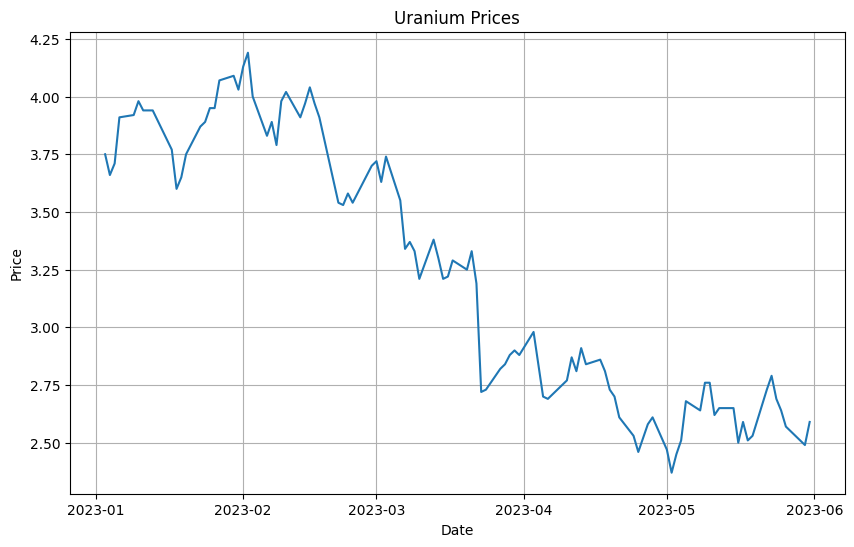

In [180]:
#plot the uranium prices
plt.figure(figsize=(10, 6))
plt.plot(uranium_prices['Close'])
plt.title('Uranium Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [181]:
import pytz
uranium_prices['Close'].index = uranium_prices['Close'].index.tz_localize(pytz.timezone('Europe/Berlin'))
combined_df = pd.concat([resampled_dict_for_uranium['generation_data']['Nuclear'], uranium_prices['Close']], axis=1)


In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Normalize the combined DataFrame for better visualization
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns)


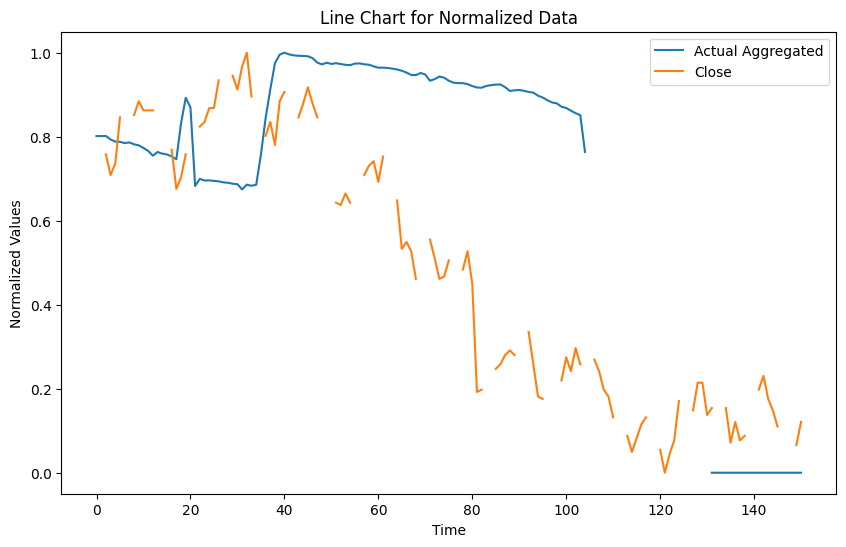

In [183]:
import matplotlib.pyplot as plt

# Plot the line chart
plt.figure(figsize=(10, 6))
for column in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df[column], label=column)

plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.title('Line Chart for Normalized Data')
plt.legend()
plt.show()


In [184]:
print(normalized_df[['Actual Aggregated']].corrwith(normalized_df['Close']))


Actual Aggregated    0.514928
dtype: float64


So the correlation between uranium prices and nuclear generation is 0.51 . Let's focus on those missin dates and dive into details

In [185]:
# print values between the 04.2023 and 05.2023
resampled_dict_for_uranium['generation_data']['Nuclear'].loc['2023-04-01':'2023-05-20'].head(60)



Actual Aggregated
2023-04-01 00:00:00+02:00        2796.531250
2023-04-02 00:00:00+02:00        2790.583333
2023-04-03 00:00:00+02:00        2782.281250
2023-04-04 00:00:00+02:00        2777.125000
2023-04-05 00:00:00+02:00        2755.052083
2023-04-06 00:00:00+02:00        2741.791667
2023-04-07 00:00:00+02:00        2721.635417
2023-04-08 00:00:00+02:00        2705.572917
2023-04-09 00:00:00+02:00        2698.614583
2023-04-10 00:00:00+02:00        2673.979167
2023-04-11 00:00:00+02:00        2665.427083
2023-04-12 00:00:00+02:00        2645.416667
2023-04-13 00:00:00+02:00        2627.270833
2023-04-14 00:00:00+02:00        2612.614583
2023-04-15 00:00:00+02:00        2344.281250
2023-04-16 00:00:00+02:00                NaN
2023-04-17 00:00:00+02:00                NaN
2023-04-18 00:00:00+02:00                NaN
2023-04-19 00:00:00+02:00                NaN
2023-04-20 00:00:00+02:00                NaN
2023-04-21 00:00:00+02:00                NaN
2023-04-22 00:00:00+02:00                NaN
2023-04-23 00:00:00+02:00                NaN
2023-04-24 00:00:00+02:00                NaN
2023-04-25 00:00:00+02:00                NaN
2023-04-26 00:00:00+02:00                NaN
2023-04-27 00:00:00+02:00                NaN
2023-04-28 00:00:00+02:00                NaN
2023-04-29 00:00:00+02:00                NaN
2023-04-30 00:00:00+02:00                NaN
2023-05-01 00:00:00+02:00                NaN
2023-05-02 00:00:00+02:00                NaN
2023-05-03 00:00:00+02:00                NaN
2023-05-04 00:00:00+02:00                NaN
2023-05-05 00:00:00+02:00                NaN
2023-05-06 00:00:00+02:00                NaN
2023-05-07 00:00:00+02:00                NaN
2023-05-08 00:00:00+02:00                NaN
2023-05-09 00:00:00+02:00                NaN
2023-05-10 00:00:00+02:00                NaN
2023-05-11 00:00:00+02:00                NaN
2023-05-12 00:00:00+02:00           0.000000
2023-05-13 00:00:00+02:00           0.000000
2023-05-14 00:00:00+02:00           0.000000
2023-05-15 00:00:00+02:00           0.000000
2023-05-16 00:00:00+02:00           0.000000
2023-05-17 00:00:00+02:00           0.000000
2023-05-18 00:00:00+02:00           0.000000
2023-05-19 00:00:00+02:00           0.000000
2023-05-20 00:00:00+02:00           0.000000

As you can see the NaN values are between the dates 16.04.2023 and 12.05.2023. And after 12.05 it is always zero. Maybe shutdown in nuclear power plant ????

BINGOOO !!! 


The last three nuclear power plants in Germany were shut down on 15 April 2023: Isar 2, Emsland and Neckarwestheim 2. Their shutdown had been planned for 31 December 2022. Due to the energy crisis, the three nuclear power plants continued operation in stretch-out mode until 15 April 2023 at the latest. ( https://www.base.bund.de/EN/ns/nuclear-phase-out/nuclear-phase-out_node.html#:~:text=The%20last%20three%20nuclear%20power%20plants%20in%20Germany%20were%20shut,April%202023%20at%20the%20latest.)

So now it make sense. We can just impute these values to 0 

#### 4.2.2 Handling missing values in Biomass generation

In [186]:
resampled_dict_for_uranium['generation_data']['Biomass'].head(20)

Actual Aggregated
2023-01-01 00:00:00+01:00                NaN
2023-01-02 00:00:00+01:00                NaN
2023-01-03 00:00:00+01:00                NaN
2023-01-04 00:00:00+01:00                NaN
2023-01-05 00:00:00+01:00                NaN
2023-01-06 00:00:00+01:00                NaN
2023-01-07 00:00:00+01:00                NaN
2023-01-08 00:00:00+01:00                NaN
2023-01-09 00:00:00+01:00                NaN
2023-01-10 00:00:00+01:00                NaN
2023-01-11 00:00:00+01:00                NaN
2023-01-12 00:00:00+01:00                NaN
2023-01-13 00:00:00+01:00        4786.854167
2023-01-14 00:00:00+01:00        4769.729167
2023-01-15 00:00:00+01:00        4704.291667
2023-01-16 00:00:00+01:00        4818.593750
2023-01-17 00:00:00+01:00        4829.593750
2023-01-18 00:00:00+01:00        4864.197917
2023-01-19 00:00:00+01:00        4833.489583
2023-01-20 00:00:00+01:00        4865.968750

* Forward Filling : Since the NaNs appear at the beginning of the dataset, you could perform a forward fill. In pandas, this can be done using the fillna method with the method set to 'ffill' (forward fill). This essentially carries forward the first valid observation down the dataframe. However, since our first value itself is NaN, forward filling won't work in this case. 

* The backward fill might be a solution here because the first valid observation occurs relatively close to the beginning of the dataset.

* Fill with Mean/Median: this assumes that the missing values are random and don't bias the data. So it is not suitable for out case

### Finding of Missing Values

* We will impute and fillna with 0 of Nuclear generation. Because The last three nuclear power plants in Germany were shut down on 15 April 2023: Isar 2, Emsland and Neckarwestheim 2. Their shutdown had been planned for 31 December 2022. Due to the energy crisis, the three nuclear power plants continued operation in stretch-out mode until 15 April 2023 at the latest. ( https://www.base.bund.de/EN/ns/nuclear-phase-out/nuclear-phase-out_node.html#:~:text=The%20last%20three%20nuclear%20power%20plants%20in%20Germany%20were%20shut,April%202023%20at%20the%20latest.) So now it make sense. We can just impute these values to 0 

* We will use backfill to handle missin values in biomass because the first valid observation occurs relatively close to the beginning of the dataset.


In [197]:
# Fill NaN values
energy_types = ['Biomass', 'Nuclear', 'Fossil Brown coal/Lignite', 'Fossil Gas', 
                'Fossil Hard coal', 'Fossil Oil', 'Geothermal', 
                'Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 
                'Hydro Water Reservoir', 'Other', 'Other renewable', 'Solar', 
                'Waste', 'Wind Offshore', 'Wind Onshore']

for energy_type in energy_types:
    if energy_type == 'Nuclear':
        resampled_dict['generation_data'][energy_type].fillna(0, inplace=True)
    elif energy_type == 'Biomass':
        resampled_dict['generation_data'][energy_type].fillna(method='bfill', inplace=True)
    else:
        resampled_dict['generation_data'][energy_type].fillna(resampled_dict['generation_data'][energy_type].mean(), inplace=True)

# Print the indices of remaining NaN values
na_indices = resampled_dict['generation_data'].index[resampled_dict['generation_data'].isna().any(axis=1)].tolist()
print("Indices of remaining NaN values:")
print(na_indices)


Indices of remaining NaN values:
[]


/tmp/ipykernel_179240/2911770143.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resampled_dict['generation_data'][energy_type].fillna(method='bfill', inplace=True)
/tmp/ipykernel_179240/2911770143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resampled_dict['generation_data'][energy_type].fillna(0, inplace=True)
/tmp/ipykernel_179240/2911770143.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resampled_dict['generation

In [213]:
na_indices = resampled_dict['weather_data'].index[resampled_dict['weather_data'].isna().any(axis=1)].tolist()
print("Indices of remaining NaN values:")
print(na_indices)

Indices of remaining NaN values:
[Timestamp('2023-02-07 09:00:00+0100', tz='Europe/Berlin'), Timestamp('2023-02-07 10:00:00+0100', tz='Europe/Berlin'), Timestamp('2023-04-21 23:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 00:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 01:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 02:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 03:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 04:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 05:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 06:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 07:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 08:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 09:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 10:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 11:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 12:00:00+0200', tz='Europe/Berlin'), Timestamp('2023-04-22 

### 4.3. Lagging the Data

* "When predicting the day ahead prices for day D, only the actual load and generation data for day D-2, will be available, this should be taken into account during pre-processing."

This is referring to the fact that when we want to predict the day ahead prices for a specific day (let's call this "day D"), we can only use actual load and generation data that's from two days before this specific day ("day D-2"). This could be because the data from the day before ("day D-1") hasn't been processed or collected yet, and so it's not available at the time when you need to make the prediction.

As a result, during preprocessing steps, we need to structure our data in such a way that for every record corresponding to "day D", we have corresponding load and generation data from "day D-2". This is why we introduced the concept of "lagging" your data by two days, to ensure this alignment.

In [201]:
lagged_to_be = [
    'generation_data',
    'load_data',
    'load_forecast',
    'generation_forecast',
    'wind_and_solar_forecast',
    'weather_data'
]

In [202]:
def lag_datasets(df_dict, data_names, lag_period=2):
    """Lags the dataframes in df_dict by the specified lag period"""
    lagged_dict = {}
    for dataset_name, df in df_dict.items():
        if dataset_name in data_names:
            df_lagged = data_handler._lag_dataframe(df, lag_period)
            lagged_dict[dataset_name] = df_lagged
        else:
            lagged_dict[dataset_name] = df
    return lagged_dict

In [203]:
# TODO change freq to 'H' 
lagged_dict = lag_datasets(resampled_dict, data_names=lagged_to_be, lag_period=2*24)  # lag by 2 days

### 4.4 Combining datasets into single df

In [216]:
def combine_data(df_dict):
    """Combines the dataframes in df_dict into a single dataframe"""
    df_combined = pd.concat(df_dict.values(), join='outer', axis=1)
    return df_combined


In [217]:
df = combine_data(lagged_dict)

In [206]:
df

Actual Load  Forecasted Load  \
2023-01-01 00:00:00+01:00          NaN              NaN   
2023-01-01 01:00:00+01:00          NaN              NaN   
2023-01-01 02:00:00+01:00          NaN              NaN   
2023-01-01 03:00:00+01:00          NaN              NaN   
2023-01-01 04:00:00+01:00          NaN              NaN   
...                                ...              ...   
2023-05-31 20:00:00+02:00     45804.25         46457.00   
2023-05-31 21:00:00+02:00     45251.25         45825.75   
2023-05-31 22:00:00+02:00     45112.50         44989.00   
2023-05-31 23:00:00+02:00     42248.00         42537.75   
2023-06-01 00:00:00+02:00          NaN              NaN   

                           (Biomass, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                           NaN   
2023-01-01 01:00:00+01:00                           NaN   
2023-01-01 02:00:00+01:00                           NaN   
2023-01-01 03:00:00+01:00                           NaN   
2023-01-01 04:00:00+01:00                           NaN   
...                                                 ...   
2023-05-31 20:00:00+02:00                       4579.50   
2023-05-31 21:00:00+02:00                       4616.25   
2023-05-31 22:00:00+02:00                       4648.25   
2023-05-31 23:00:00+02:00                       4663.50   
2023-06-01 00:00:00+02:00                           NaN   

                           (Fossil Brown coal/Lignite, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                             NaN   
2023-01-01 01:00:00+01:00                                             NaN   
2023-01-01 02:00:00+01:00                                             NaN   
2023-01-01 03:00:00+01:00                                             NaN   
2023-01-01 04:00:00+01:00                                             NaN   
...                                                                   ...   
2023-05-31 20:00:00+02:00                                         3861.00   
2023-05-31 21:00:00+02:00                                         4030.00   
2023-05-31 22:00:00+02:00                                         3946.75   
2023-05-31 23:00:00+02:00                                         3713.00   
2023-06-01 00:00:00+02:00                                             NaN   

                           (Fossil Gas, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                              NaN   
2023-01-01 01:00:00+01:00                              NaN   
2023-01-01 02:00:00+01:00                              NaN   
2023-01-01 03:00:00+01:00                              NaN   
2023-01-01 04:00:00+01:00                              NaN   
...                                                    ...   
2023-05-31 20:00:00+02:00                          3653.50   
2023-05-31 21:00:00+02:00                          3978.00   
2023-05-31 22:00:00+02:00                          3683.00   
2023-05-31 23:00:00+02:00                          3729.75   
2023-06-01 00:00:00+02:00                              NaN   

                           (Fossil Hard coal, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                    NaN   
2023-01-01 01:00:00+01:00                                    NaN   
2023-01-01 02:00:00+01:00                                    NaN   
2023-01-01 03:00:00+01:00                                    NaN   
2023-01-01 04:00:00+01:00                                    NaN   
...                                                          ...   
2023-05-31 20:00:00+02:00                                1323.00   
2023-05-31 21:00:00+02:00                                1422.50   
2023-05-31 22:00:00+02:00                                1466.00   
2023-05-31 23:00:00+02:00                                1368.25   
2023-06-01 00:00:00+02:00                                    NaN   

                           (Fossil Oil, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                              NaN  

In [218]:
df.dropna(inplace=True)

In [219]:
df

Actual Load  Forecasted Load  \
2023-01-03 00:00:00+01:00     38931.75         42215.50   
2023-01-03 01:00:00+01:00     38314.00         40026.75   
2023-01-03 02:00:00+01:00     37470.25         38631.25   
2023-01-03 03:00:00+01:00     36497.75         37588.50   
2023-01-03 04:00:00+01:00     36065.00         37705.75   
...                                ...              ...   
2023-05-31 19:00:00+02:00     45979.25         47162.75   
2023-05-31 20:00:00+02:00     45804.25         46457.00   
2023-05-31 21:00:00+02:00     45251.25         45825.75   
2023-05-31 22:00:00+02:00     45112.50         44989.00   
2023-05-31 23:00:00+02:00     42248.00         42537.75   

                           (Biomass, Actual Aggregated)  \
2023-01-03 00:00:00+01:00                       4591.25   
2023-01-03 01:00:00+01:00                       4591.25   
2023-01-03 02:00:00+01:00                       4591.25   
2023-01-03 03:00:00+01:00                       4591.25   
2023-01-03 04:00:00+01:00                       4591.25   
...                                                 ...   
2023-05-31 19:00:00+02:00                       4525.75   
2023-05-31 20:00:00+02:00                       4579.50   
2023-05-31 21:00:00+02:00                       4616.25   
2023-05-31 22:00:00+02:00                       4648.25   
2023-05-31 23:00:00+02:00                       4663.50   

                           (Fossil Brown coal/Lignite, Actual Aggregated)  \
2023-01-03 00:00:00+01:00                                         3859.25   
2023-01-03 01:00:00+01:00                                         3866.50   
2023-01-03 02:00:00+01:00                                         3860.25   
2023-01-03 03:00:00+01:00                                         3864.75   
2023-01-03 04:00:00+01:00                                         3841.00   
...                                                                   ...   
2023-05-31 19:00:00+02:00                                         3643.25   
2023-05-31 20:00:00+02:00                                         3861.00   
2023-05-31 21:00:00+02:00                                         4030.00   
2023-05-31 22:00:00+02:00                                         3946.75   
2023-05-31 23:00:00+02:00                                         3713.00   

                           (Fossil Gas, Actual Aggregated)  \
2023-01-03 00:00:00+01:00                          2469.00   
2023-01-03 01:00:00+01:00                          2292.25   
2023-01-03 02:00:00+01:00                          2240.50   
2023-01-03 03:00:00+01:00                          2243.75   
2023-01-03 04:00:00+01:00                          2254.75   
...                                                    ...   
2023-05-31 19:00:00+02:00                          3267.00   
2023-05-31 20:00:00+02:00                          3653.50   
2023-05-31 21:00:00+02:00                          3978.00   
2023-05-31 22:00:00+02:00                          3683.00   
2023-05-31 23:00:00+02:00                          3729.75   

                           (Fossil Hard coal, Actual Aggregated)  \
2023-01-03 00:00:00+01:00                                2067.50   
2023-01-03 01:00:00+01:00                                2052.00   
2023-01-03 02:00:00+01:00                                2034.25   
2023-01-03 03:00:00+01:00                                2037.00   
2023-01-03 04:00:00+01:00                                2040.25   
...                                                          ...   
2023-05-31 19:00:00+02:00                                1350.25   
2023-05-31 20:00:00+02:00                                1323.00   
2023-05-31 21:00:00+02:00                                1422.50   
2023-05-31 22:00:00+02:00                                1466.00   
2023-05-31 23:00:00+02:00                                1368.25   

                           (Fossil Oil, Actual Aggregated)  \
2023-01-03 00:00:00+01:00                             8.00  

## 4. Feature Engineering

In [222]:
data = df.copy()